In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torchvision.transforms as T
from torchvision import transforms

import mne
from mne.viz import plot_topomap
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test
from mne.time_frequency import tfr_multitaper, tfr_stockwell
from mne.decoding import GeneralizingEstimator, cross_val_multiscore

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

from scipy.stats import spearmanr, pearsonr, sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform

import cornet
from cornet import CORnet_S, cornet_s

# Loading the data and preparing the Data for all the tasks(RDm, svm and etc.)

In [2]:
min_time, max_time = -0.2, 0.6
sample_freq = 256

window_size = 0.01
slide_size = 0.005

times = np.linspace(min_time, max_time, int((max_time - min_time) * sample_freq) + 1)
window_samples = int(window_size * sample_freq)
step_samples = int(slide_size * sample_freq)
sliding_windows = []
for start in range(0, len(times) - window_samples, step_samples):
    stop = start + window_samples
    sliding_windows.append((start, stop))

In [ ]:
smoothed_accuracies = []
time_axis = []
faces = []
houses = []
all_epochs = []
faces_rdm = []
houses_rdm = []
index = []
rdms = []
for i in range(1, 11):
    print(i)
    eeglab_file = f'sub{i}.set'

    epochs = mne.read_epochs_eeglab(eeglab_file)
    epochs = epochs.crop(tmin=-0.2, tmax=0.6)
    all_epochs.append(epochs)
    excluded_labels = ['4362/4969']
    house_index = []
    for h in epochs.event_id:
        if h.startswith('436') and h not in excluded_labels:
            house_index.append(h)
    face_index = []
    for h in epochs.event_id:
        if h.startswith('496') and h not in excluded_labels:
            face_index.append(h)


    face_avg = []
    house_avg = []

    for j in house_index:
        house_epoch = epochs[j].average()
        house_avg.append(house_epoch)

    for j in face_index:
        face_epoch = epochs[j].average()
        face_avg.append(face_epoch)
    all_avg = house_avg + face_avg
    all_index = house_index + face_index
    faces_rdm.append(face_avg)
    houses_rdm.append(house_avg)
    index.append(all_index)

    rdm_size = len(all_avg)

    epochs_data = []
    for j in all_avg:
        data = j.get_data().squeeze()
        epochs_data.append(data)
    epochs_data = np.array(epochs_data)

    num_channel = epochs_data.shape[1]
    num_time = epochs_data.shape[2]
    epochs_data = epochs_data.reshape(rdm_size, -1)

    rdm = pairwise_distances(epochs_data, metric = 'correlation')


    face = epochs[face_index]
    house = epochs[house_index]

    faces.append(face.average())
    houses.append(house.average())

    house_epochs = epochs[house_index]
    face_epochs = epochs[face_index]
    X = np.concatenate([house_epochs.get_data(), face_epochs.get_data()], axis=0)
    y = []
    for _ in range(len(house_epochs)):
        y.append(0)
    for _ in range(len(face_epochs)):
        y.append(1)

    tmin, tmax = -0.2 , 0.6
    window_size = 0.01 
    step_size = 0.005   

    times = epochs.times
    sfreq = epochs.info['sfreq']
    n_times = X.shape[2]

    start_sample = np.searchsorted(times, tmin)
    end_sample = np.searchsorted(times, tmax)

    window_samples = int(window_size * sfreq)
    step_samples = int(step_size * sfreq)

    accuracies = []
    time_centers = []

    time_rdm = []

    for start, stop in sliding_windows:
        stop = start + window_samples

        condition_averages = []
        for cond in all_index:
            cond_epochs = epochs[cond]
            data_window = cond_epochs.get_data()[:, :, start:stop]
            avg_vector = data_window.mean(axis=0).reshape(-1)
            condition_averages.append(avg_vector)
        condition_averages = np.vstack(condition_averages)

        rdm_window = pairwise_distances(condition_averages, metric='correlation')

        time_rdm.append(rdm_window)
    
    rdms.append(time_rdm)


    for start, stop in sliding_windows:
        stop = start + window_samples
        time_center = times[start:stop].mean()
        
        X_window = X[:, :, start:stop].reshape(X.shape[0], -1)
        
        X_window = StandardScaler().fit_transform(X_window)

        clf = SVC(kernel='linear')
        scores = cross_val_score(clf, X_window, y, cv=5)
        accuracies.append(scores.mean())
        time_centers.append(time_center)
    time_axis.append(time_centers)
    smoooth_accuracy = gaussian_filter1d(accuracies, sigma=2)
    smoothed_accuracies.append(smoooth_accuracy)

# ERP

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_32260\3389983921.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


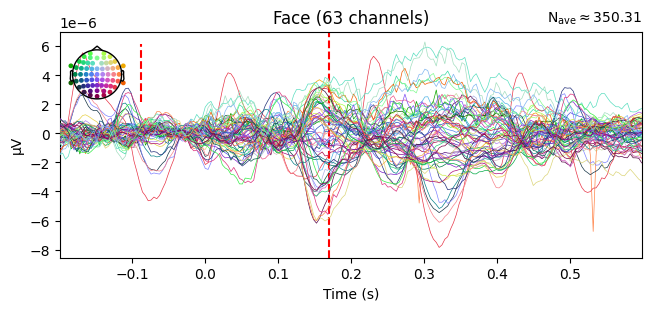

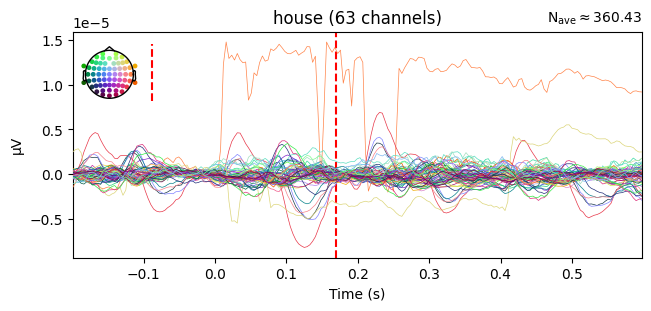

In [12]:
grand_face = mne.combine_evoked(faces, weights='equal')
grand_house = mne.combine_evoked(houses, weights='equal')

fig = grand_face.plot( titles='Face', show=False)

for ax in fig.axes:
    ax.axvline(x=0.17, color='red', linestyle='--',)

fig = grand_house.plot(titles='house', show=False)


for ax in fig.axes:
    ax.axvline(x=0.17, color='red', linestyle='--')

fig.show()

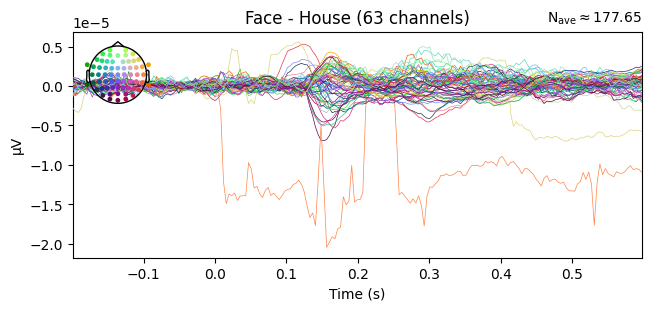

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_21260\520344369.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [4]:
difference = mne.combine_evoked([grand_face, grand_house], weights=[1, -1])
difference.plot(time_unit='s', titles='Face - House')
fig.show()

In [13]:
X_faces = np.array([evk.data for evk in faces])
X_houses = np.array([evk.data for evk in houses])

x_faces = []
x_houses = []
for t in faces:
    x_faces.append(t.data)
x_faces = np.array(x_faces)
for t in houses:
    x_houses.append(t.data)
x_houses = np.array(x_houses)

In [ ]:
picks = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8','P7', 'P8', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6','FT9', 'FT10', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4','FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6','AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'CPz', 'POz', 'Oz', 'Afz', 'FCz']

ch_indices = []
for ch in picks:
    ch_indices.append(faces[0].ch_names.index(ch))

x_faces_avg = x_faces[:, ch_indices, :].mean(axis=1)
x_houses_avg = x_houses[:, ch_indices, :].mean(axis=1)


T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [x_faces_avg, x_houses_avg],
    n_permutations=1000,
    tail=0,
    n_jobs=1,
    threshold=None,
    out_type='mask'
)

Using a threshold of 4.413873
stat_fun(H1): min=0.002668460748638329 max=31.69678240154222
Running initial clustering …
Found 7 clusters


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_32260\346173584.py:14: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 999/999 [00:00<00:00, 9968.79it/s]


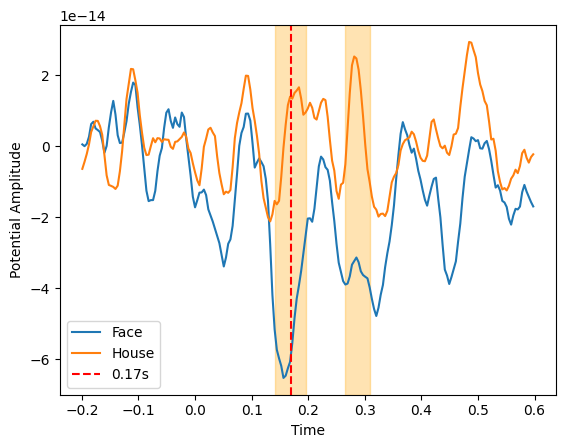

In [ ]:
times = faces[0].times
plt.plot(times, x_faces_avg.mean(axis=0), label='Face')
plt.plot(times, x_houses_avg.mean(axis=0), label='House')
plt.axvline(0.17, color='red', linestyle='--', label='0.17s')

for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] < 0.05:
        h = c
        plt.axvspan(times[h][0], times[h][-1], color='orange', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Potential Amplitude')
plt.legend()
plt.show()

# MVPA

In [28]:
interpolated_accuracies = []
time_pints = np.linspace(-0.2, 0.6, 200)

for i in range(len(smoothed_accuracies)):
    times = np.array(time_axis[i])
    acc = np.array(smoothed_accuracies[i])
    
    interpolator = interp1d(times, acc, kind='linear', bounds_error=False, fill_value='extrapolate')
    acc_interp = interpolator(time_pints)
    interpolated_accuracies.append(acc_interp)

interpolated_accuracies = np.array(interpolated_accuracies)

In [29]:
mean_acc = np.mean(interpolated_accuracies, axis=0)
stderr = sem(interpolated_accuracies, axis=0)
ci_upper = mean_acc + 1.96 * stderr
ci_lower = mean_acc - 1.96 * stderr

In [30]:
x = np.array(interpolated_accuracies)
x = x - 0.5 

In [31]:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    x,
    n_permutations=1000,
    threshold=5,
    tail=1,
    out_type='mask',
    n_jobs=1
)

stat_fun(H1): min=-2.1809617328378494 max=7.659506633031279
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 999/999 [00:00<00:00, 20734.70it/s]


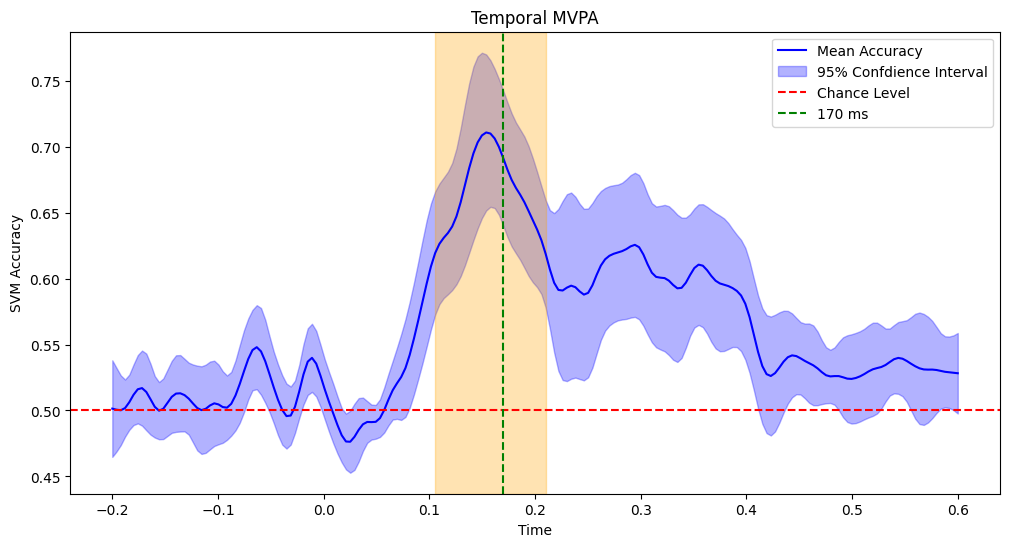

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(time_pints, mean_acc, label='Mean Accuracy', color='blue')
plt.fill_between(time_pints, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% Confdience Interval')
plt.axhline(0.5, color='red', linestyle='--', label='Chance Level')
plt.axvline(0.17, color='green', linestyle='--', label='170 ms')


for i_c, cluster in enumerate(clusters):
    if cluster_p_values[i_c] < 0.01:
        time_inds = cluster
        cluster_times = time_pints[time_inds]
        plt.axvspan(cluster_times[0], cluster_times[-1], color='orange', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('SVM Accuracy')
plt.title('Temporal MVPA')
plt.legend()
plt.show()

In [33]:
min_time, max_time = 0.13, 0.19  

start = np.searchsorted(times, min_time)
stop  = np.searchsorted(times, max_time)

X_window = X[:, :, start:stop].mean(axis=2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_window)

clf = SVC(kernel='linear')
scores = cross_val_score(clf, X_scaled, y, cv=5)
print("Mean spatial decoding acc:", np.mean(scores))

Mean spatial decoding acc: 0.8742857142857142


In [34]:
clf.fit(X_scaled, y)
weights = clf.coef_.ravel()  

In [35]:
time_centers = []
accuracies = []
weight_maps = []

window_samples = int(0.01 * sfreq)
step_samples   = int(0.005 * sfreq)

for start in range(start_sample, end_sample - window_samples, step_samples):
    stop = start + window_samples
    center = times[start:stop].mean()
    Xw = X[:, :, start:stop].mean(axis=2)
    scores = cross_val_score(clf, Xw, y, cv=5)
    accuracies.append(scores.mean())
    time_centers.append(center)
    clf.fit(Xw, y)
    weight_maps.append(clf.coef_.ravel())

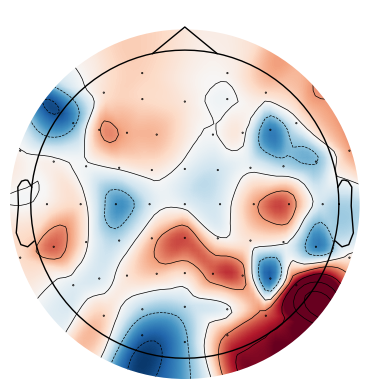

In [36]:
fig, ax = plt.subplots()
im, pos = plot_topomap(weights, epochs.info, axes=ax, show=False)

plt.show()

In [37]:
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
time_gen = GeneralizingEstimator(clf, scoring='accuracy', n_jobs=-1, verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5)
scores = scores.mean(axis=0)

100%|██████████| Fitting GeneralizingEstimator : 205/205 [00:05<00:00,   38.61it/s]
100%|██████████| Scoring GeneralizingEstimator : 42025/42025 [00:04<00:00, 8870.96it/s]
100%|██████████| Fitting GeneralizingEstimator : 205/205 [00:00<00:00, 2138.35it/s]
100%|██████████| Scoring GeneralizingEstimator : 42025/42025 [00:04<00:00, 8909.13it/s] 
100%|██████████| Fitting GeneralizingEstimator : 205/205 [00:00<00:00, 1365.28it/s]
100%|██████████| Scoring GeneralizingEstimator : 42025/42025 [00:04<00:00, 9156.73it/s] 
100%|██████████| Fitting GeneralizingEstimator : 205/205 [00:00<00:00, 1995.40it/s]
100%|██████████| Scoring GeneralizingEstimator : 42025/42025 [00:04<00:00, 9049.22it/s] 
100%|██████████| Fitting GeneralizingEstimator : 205/205 [00:00<00:00, 2061.82it/s]
100%|██████████| Scoring GeneralizingEstimator : 42025/42025 [00:04<00:00, 9245.91it/s] 


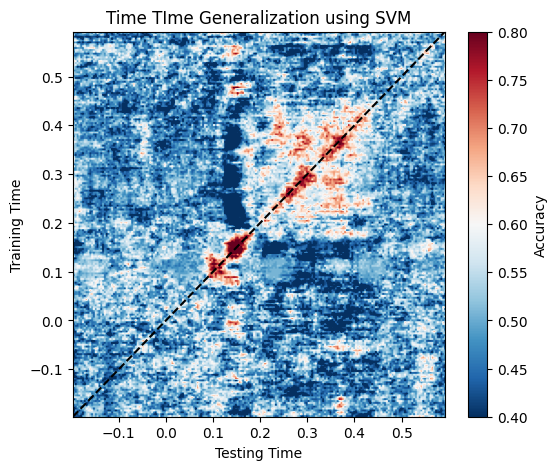

In [38]:
plt.figure(figsize=(6, 5))
plt.imshow(scores, origin='lower', aspect='auto',extent=[times[0], times[-1], times[0], times[-1]],cmap='RdBu_r', vmin=0.4, vmax=0.8)
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.colorbar(label='Accuracy')
plt.title('Time TIme Generalization using SVM')
plt.plot(times, times, '--k')
plt.show()

# Time-Frequency Analysis

In [22]:
freqs = np.arange(6, 100, 2)
n_cycles = freqs / 2
time_bandwidth = 2.0

time_window = (-0.2, 0.6)

tfr_faces = mne.time_frequency.tfr_multitaper(faces[0], freqs=freqs, n_cycles=n_cycles,
time_bandwidth=time_bandwidth, return_itc=False, picks='eeg')

tfr_houses = mne.time_frequency.tfr_multitaper(houses[0], freqs=freqs, n_cycles=n_cycles,
time_bandwidth=time_bandwidth, return_itc=False,picks='eeg')


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


No baseline correction applied


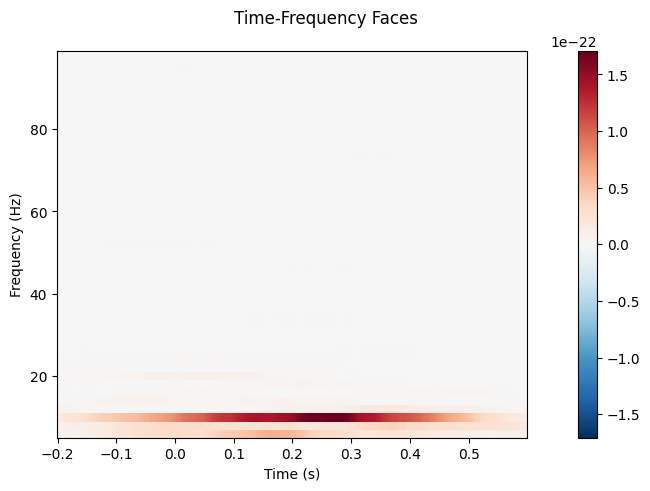

In [23]:
tfr_faces.plot([0],  mode='logratio', title='Time-Frequency Faces')
plt.show()

Applying baseline correction (mode: logratio)


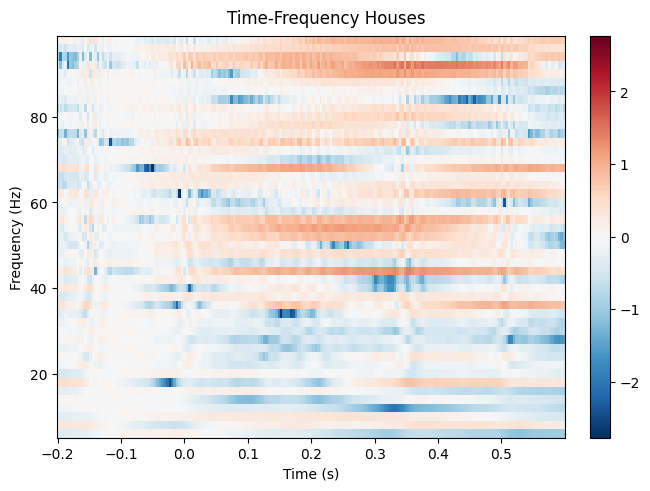

In [24]:
tfr_houses.plot([0], baseline=(-0.2, 0), mode='logratio', title='Time-Frequency Houses')


plt.show()

# RDM and cornet model

In [39]:
rdms_by_time = list(zip(*rdms))

avg_time_rdms = []

for time_rdms in rdms_by_time:
    stacked = np.stack(time_rdms, axis=0)
    mean_rdm = np.mean(stacked, axis=0)
    avg_time_rdms.append(mean_rdm)

In [ ]:
model = cornet_s(pretrained=True, map_location=torch.device('cpu'))
model.eval()

In [20]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0)

In [29]:
image_paths = glob.glob('Stimuli/*.jpg')
images = [load_image(p) for p in image_paths]

In [32]:
net = model.module if hasattr(model, 'module') else model

features = {'V1': [], 'V2': [], 'V4': [], 'IT': []}

def hook(layer_name):
    def fn(module, input, output):
        features[layer_name].append(output.detach().cpu().numpy())
    return fn

net.V1.register_forward_hook(hook('V1'))
net.V2.register_forward_hook(hook('V2'))
net.V4.register_forward_hook(hook('V4'))
net.IT.register_forward_hook(hook('IT'))

In [33]:
with torch.no_grad():
    for img in images:
        img = img
        model(img)

In [ ]:
layer_features = {}
for layer in features:

    layer_features[layer] = [f.flatten() for f in features[layer]]
    layer_features[layer] = np.stack(layer_features[layer])

In [ ]:
rdms_cor = {}
for layer in layer_features:

    rdm = squareform(pdist(layer_features[layer], metric='correlation'))
    rdms_cor[layer] = rdm

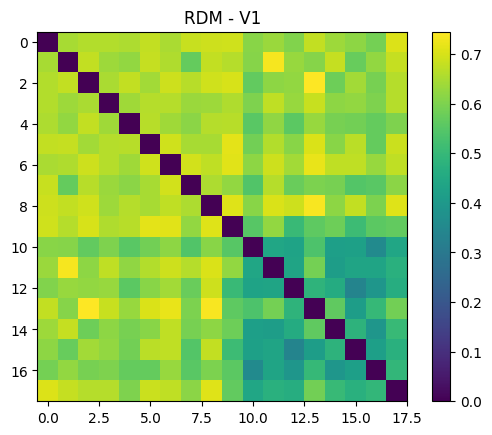

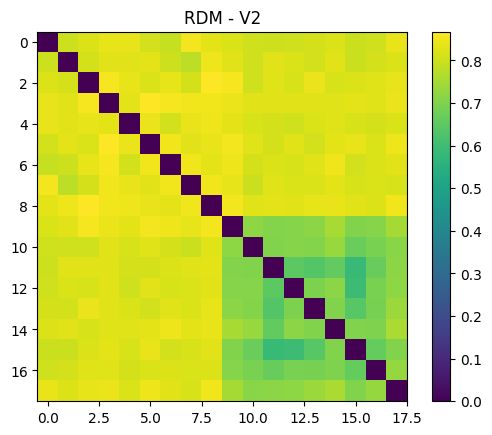

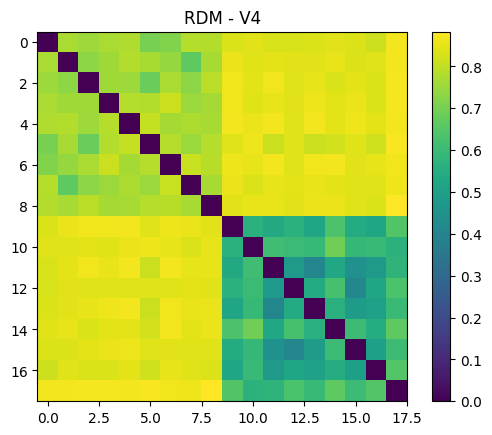

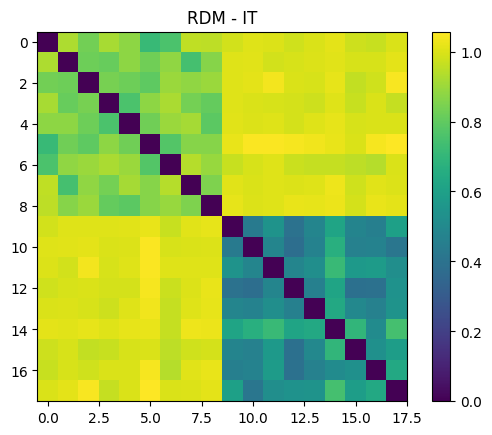

In [ ]:
for layer in rdms_cor:
    plt.figure()
    plt.imshow(rdms_cor[layer], cmap='viridis')
    plt.title(f'RDM - {layer}')
    plt.colorbar()
    plt.show()


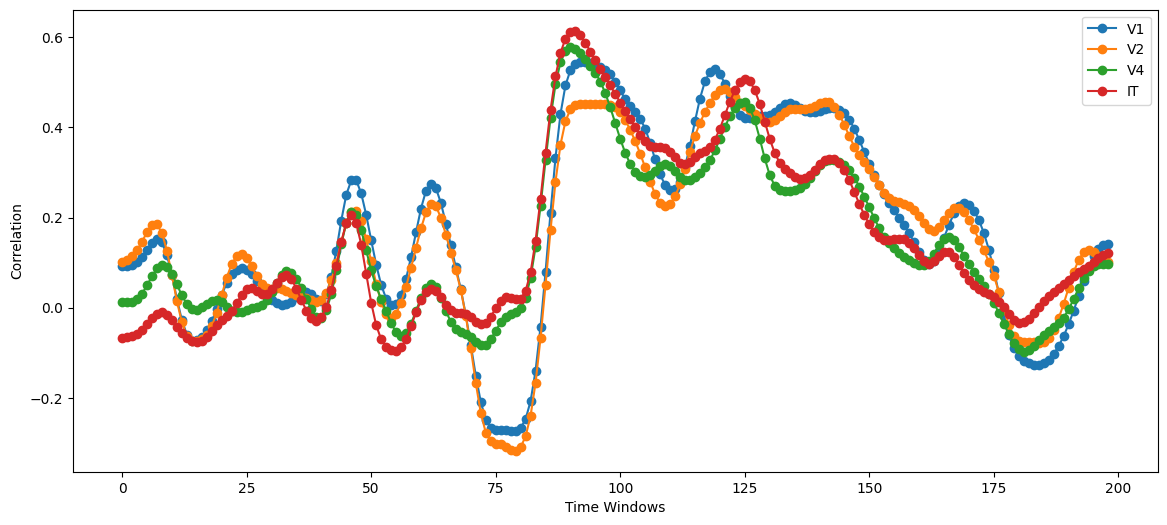

In [47]:
layer_correlations = {}
for layer, rdm_core_matrix in rdms_cor.items():
    correlations = []

    core_flat = rdm_core_matrix[np.triu_indices_from(rdm_core_matrix, k=1)]

    for rdm in avg_time_rdms:
        rdm_flat = rdm[np.triu_indices_from(rdm, k=1)]
        corr, _ = spearmanr(core_flat, rdm_flat)
        correlations.append(corr)
    
    layer_correlations[layer] = correlations

plt.figure(figsize=(14, 6))
time_axis = np.arange(len(avg_time_rdms)) 

for layer, corrs in layer_correlations.items():
    plt.plot(time_axis, gaussian_filter1d(corrs, sigma = 2), marker='o', label=f'{layer}')


plt.xlabel('Time Windows')
plt.ylabel('Correlation')
plt.legend()
plt.show()